My Replication of Ethan Dinh's findings

Final shape after Ethan's preprocessing: (9256, 17)
X shape: (9256, 16)
Features used: ['schedule_playoff', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'elo1_pre', 'elo2_pre', 'pred_home_win', 'qbelo1_pre', 'qbelo2_pre', 'pred_homeQB_win', 'home_favorite', 'over_line', 'qb1_relative', 'qb1_pre_relative_value', 'qb1_relative_adj']
Train/Test sizes: (6479, 16) (2777, 16)
Home-win rate train/test: 0.577 0.592
Random Forest Hyperparameter Tuning
100%|██████████| 100/100 [07:11<00:00,  4.31s/trial, best loss: 0.22271867105200438]
Best RF (Hyperopt): {'criterion': np.int64(1), 'max_depth': np.float64(5.0), 'n_estimators': np.float64(15.0)}


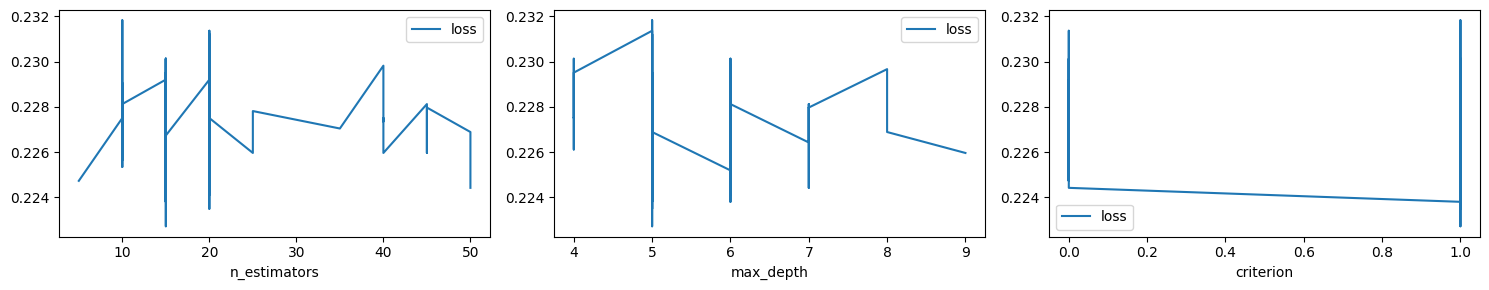


Logistic Regression C Parameter Tuning


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

Best Score: 0.7768176509843177
Best Hyperparameters: {'C': 0.01}


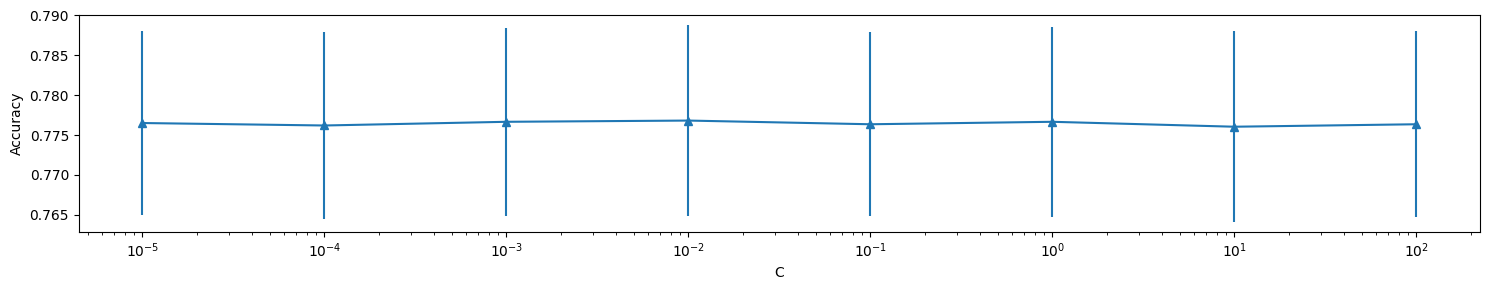

Best C parameter: 0.01

XGBoost Hyperparameter Tuning
100%|██████████| 100/100 [49:25<00:00, 29.65s/trial, best loss: 0.22410815577482246]
Best XGB (Hyperopt): {'learning_rate': np.float64(0.17788292218443907), 'max_depth': np.int64(0), 'n_estimators': np.int64(63)}


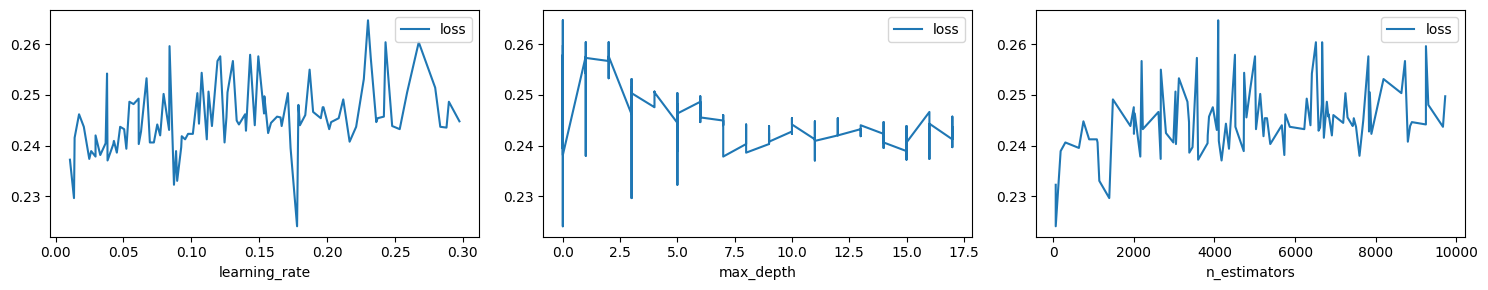


Training Models with Tuned Parameters
All tuned models trained successfully!

=== Random Forest (tuned) ===
Accuracy:  0.7645
Precision: 0.7983
Recall:    0.8061
F1:        0.8022
AUROC:     0.8325


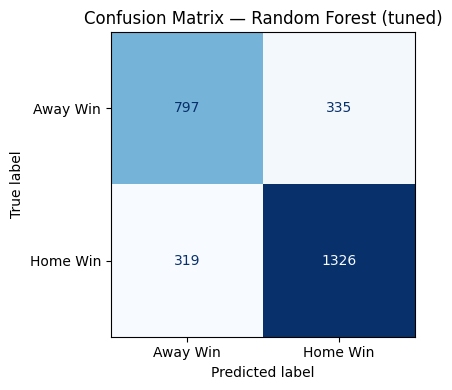


=== Logistic Regression (scaled) ===
Accuracy:  0.7731
Precision: 0.7998
Recall:    0.8231
F1:        0.8113
AUROC:     0.8417


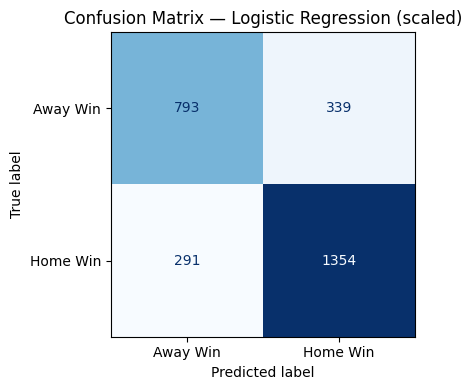


=== XGBoost (tuned) ===
Accuracy:  0.7649
Precision: 0.7942
Recall:    0.8140
F1:        0.8040
AUROC:     0.8392


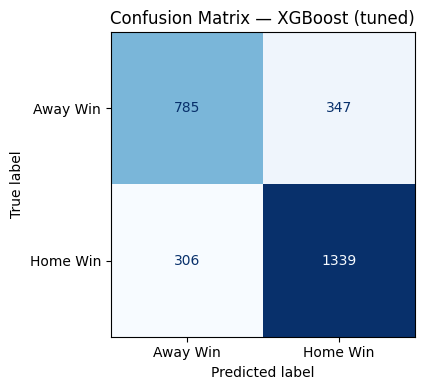


Summary:
                           Model       acc      prec       rec        f1  \
0         Random Forest (tuned)  0.764494  0.798314  0.806079  0.802178   
1  Logistic Regression (scaled)  0.773136  0.799764  0.823100  0.811264   
2               XGBoost (tuned)  0.764854  0.794187  0.813982  0.803963   

      auroc  
0  0.832455  
1  0.841680  
2  0.839225  

CV Acc — RF: [0.7603 0.7844 0.7682 0.772  0.758 ] mean: 0.7686
CV Acc — LR: [0.7765 0.7882 0.7812 0.7801 0.758 ] mean: 0.7768
Paired t-test (H1: LR > RF): t=2.788, p=0.024712

EXTRAPOLATION: Testing on 2019+ Data
Extrapolation datasets prepared:
Train (pre-2019): (9005, 16)
Test (2019+): (251, 16)
Model Win Percentage: 0.8086
Total Number of Bets Won: 169
Total Number of Bets Made: 209
Possible Games: 251


In [134]:
# NFL Game Outcome Prediction (RF, LR, XGB)
# 
# Replication of Ethan Dinh's NFL Prediction Project
# Original Repository: https://github.com/ethan-dinh/NFL-Prediction
# 
# Attribution:
# - Core methodology and preprocessing pipeline from Ethan Dinh's original work
# - Hyperparameter tuning approach and optimization strategies
# - Feature engineering and data integration logic
# - Experimental design and evaluation framework
#
# Modifications and Enhancements:
# - Added comprehensive classification metrics (Precision, Recall, F1, AUROC)
# - Enhanced reproducibility with fixed random seeds
# - Additional visualization and statistical analysis
# - Updated to current machine learning library versions
#
# Original work by: Ethan Dinh
# Replication by: Johnathan Gutierrez-Diaz
# Date: 10/24/2025
import os, numpy as np, pandas as pd
from scipy import stats as scipy_stats
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score,
                             confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, anneal

# Used seed for replication purposes
SEED = 42
np.random.seed(SEED)
os.makedirs("outputs", exist_ok=True)

# Load datasets exactly like Ethan
NFL_GAMES_PATH = 'Data/nfl_games.csv'
NFL_TEAMS_PATH = 'Data/nfl_teams.csv'
NFL_SPREAD_PATH = 'Data/spreadspoke_scores.csv'

games = pd.read_csv(NFL_GAMES_PATH)
teams = pd.read_csv(NFL_TEAMS_PATH)
df = pd.read_csv(NFL_SPREAD_PATH).replace(r'^\s*$', np.nan, regex=True)

# Because of modern changes to the Washington Redskins now Commanders we must add WAS
team_dict = teams.set_index('team_name')['team_id'].to_dict()
team_dict["Washington Redskins"] = "WAS" 

team_home, team_away = [], []
for name in df["team_home"]:
    team_home.append(team_dict[name])

for name in df["team_away"]:
    team_away.append(team_dict[name])

df["team_away"] = team_away
df["team_home"] = team_home

# Converting to schedule date to date time
df["schedule_date"] = pd.to_datetime(df["schedule_date"])
games["date"] = pd.to_datetime(games["date"])

df = df.merge(games, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

# Creating a quantitative column (0 or 1) for which team is the favorite: home or away
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)

# Converting the over-under line to ints instead of strings
df.over_under_line.fillna(0, inplace=True)
df["over_under_line"] = df["over_under_line"].astype(float)

# Creating a quantitative column (0 or 1) for the over under betting line
df.loc[((df.score_home + df.score_away) > (df.over_under_line)), "over_line"] = 1
df.over_line.fillna(0, inplace=True)

# Converting schedule_playoff to 1 or 0
df["schedule_playoff"] = df["schedule_playoff"].astype(int)

# Converting stadium neutrality to 1 or 0
df["stadium_neutral"] = df["stadium_neutral"].astype(int)

# Fixing schedule_week
df.loc[(df.schedule_week == "Superbowl"), "schedule_week"] = 21
df.loc[(df.schedule_week == "SuperBowl"), "schedule_week"] = 21
df.loc[(df.schedule_week == "Conference"), "schedule_week"] = 20
df.loc[(df.schedule_week == "Division"), "schedule_week"] = 19
df.loc[(df.schedule_week == "Wildcard"), "schedule_week"] = 18
df.loc[(df.schedule_week == "WildCard"), "schedule_week"] = 18

# Removing unnecessary columns
df = df.drop(columns = ["stadium", "weather_detail"])

# Creating a results columns – if the home team won
df.loc[(df.score_home > df.score_away), "result"] = 1
df.result.fillna(0, inplace=True)

# Removing the 1966 - 1980 Seasons
for i in range(1966, 1980):
    df = df[df["schedule_season"] != i]

# Dropping redundant columns
df = df.drop(columns = ["date", "score1", "score2", "playoff", "qb1", "qb2", "team1", "team2"])

# Dropping all columns with 'post'
for column_name in df.columns:
    if "post" in column_name:
        df = df.drop(columns = column_name)

# Replace the NA weather data with the average of the column
for col_name in ["weather_temperature", "weather_wind_mph", "weather_humidity"]:
    df[col_name] = df[col_name].astype(float)
    df[col_name] = df[col_name].fillna(np.mean(df[col_name]))

# Combining qb1 and qb2 values
df["qb1_relative"] = df["qb1_game_value"] - df["qb2_game_value"]
df["qb1_pre_relative_value"] = df["qb1_value_pre"] - df["qb2_value_pre"]
df["qb1_relative_adj"] = df["qb1_adj"] - df["qb2_adj"]

# Renaming columns
df.rename(columns = {"elo_prob1": "pred_home_win", "qbelo_prob1": "pred_homeQB_win"}, inplace = True)

# Remove all null rows
df = df.dropna()

# Prepares Data for extrapulation
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2019]
test = test.loc[test['schedule_season'] > 2018]

# Dropping all columns that will not be analyzed
df = df.drop(columns = ["team_away", "team_home", "score_home", "score_away", "team_favorite_id", 
                       "schedule_season", "over_under_line", "spread_favorite", "season", "neutral", 
                       "schedule_week", "qb1_game_value", "qb2_game_value", "qb1_value_pre","qb2_value_pre", 
                       "elo_prob2", "qb1_adj", "qb2_adj", "qbelo_prob2","schedule_date"])

print("Final shape after Ethan's preprocessing:", df.shape)

# Data set and split
X = df.drop(columns=["result"]) 
y = df["result"].copy() 

print("X shape:", X.shape)
print("Features used:", X.columns.tolist())

# Use Ethan's parameters but add seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=SEED 
)

print("Train/Test sizes:", X_train.shape, X_test.shape)
print("Home-win rate train/test:", y_train.mean().round(3), y_test.mean().round(3))

# Identify numeric columns for scaling
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scale_transformer = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False
)

# Hyperparameter search/plot blocks

# Random Forest Hyperopt
print("Random Forest Hyperparameter Tuning")

RF = RandomForestClassifier()
LR = LogisticRegression()
xg_classify = XGBClassifier()

def RF_objective(parameter_space):
    Error = 1 - cross_val_score(RF, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': Error, 'status': STATUS_OK}

def XGB_objective(parameter_space):
    parameter_space = {
        'max_depth': parameter_space['max_depth'],
        'learning_rate': parameter_space['learning_rate'],
        'n_estimators': parameter_space['n_estimators']
    }
    xg_classify = XGBClassifier(**parameter_space)
    XGB_error = 1 - cross_val_score(xg_classify, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': XGB_error, 'status': STATUS_OK}

RF_parameter_space = { 
    'n_estimators': hp.quniform('n_estimators', 5, 50, 5),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Finding out which set of hyperparameters give highest accuracy
RF_trials = Trials()
RF_best_params = fmin(fn=RF_objective,
            space=RF_parameter_space,
            algo=anneal.suggest,  # Ethan uses anneal.suggest
            max_evals=100,
            trials=RF_trials)

print("Best RF (Hyperopt):", RF_best_params)

# Create RF search results DataFrame and plots (EXACTLY like Ethan's)
RF_search_results = pd.DataFrame({
    'loss': RF_trials.losses(), 
    'n_estimators': RF_trials.vals['n_estimators'],
    'max_depth': RF_trials.vals['max_depth'],
    'criterion': RF_trials.vals['criterion']
})

fig, subPlots = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
RF_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[0])
RF_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
RF_search_results.sort_values(by='criterion').plot(x='criterion', y='loss', ax=subPlots[2])

plt.tight_layout()
plt.savefig("outputs/rf_hyperopt_tuning.png", bbox_inches="tight", dpi=300)
plt.show()

# Logistic Regression C-sweep
print("\nLogistic Regression C Parameter Tuning")

space = dict()
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(LR, space, scoring='accuracy', n_jobs=-1, cv=5)
LR_result = search.fit(X_train, y_train)

print('Best Score: %s' % LR_result.best_score_)
print('Best Hyperparameters: %s' % LR_result.best_params_)


scores = LR_result.cv_results_
means_test = scores["mean_test_score"]
std_test = scores["std_test_score"]
x = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# Creating plot
fig = plt.figure(figsize=(15, 3))
plt.errorbar(x, means_test, std_test, marker='^')
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Get best C parameter
best_C = LR_result.best_params_['C']
print(f"Best C parameter: {best_C}")

# XGBoost Hyperopt
print("\nXGBoost Hyperparameter Tuning")

XGB_parameter_space = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
    "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
}

# Finding out which set of hyperparameters give highest accuracy
XGB_trials = Trials()

XGB_best_params = fmin(fn=XGB_objective,
            space=XGB_parameter_space,
            algo=tpe.suggest, 
            max_evals=100,
            trials=XGB_trials)

print("Best XGB (Hyperopt):", XGB_best_params)

# Create XGB search results DataFrame and plots
XGB_search_results = pd.DataFrame({
    'loss': XGB_trials.losses(), 
    'learning_rate': XGB_trials.vals['learning_rate'],
    'max_depth': XGB_trials.vals['max_depth'],
    'n_estimators': XGB_trials.vals['n_estimators']
})

fig, subPlots = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
XGB_search_results.sort_values(by='learning_rate').plot(x='learning_rate', y='loss', ax=subPlots[0])
XGB_search_results.sort_values(by='max_depth').plot(x='max_depth', y='loss', ax=subPlots[1])
XGB_search_results.sort_values(by='n_estimators').plot(x='n_estimators', y='loss', ax=subPlots[2])

plt.tight_layout()
plt.savefig("outputs/xgb_hyperopt_tuning.png", bbox_inches="tight", dpi=300)
plt.show()


# Models with tuned parameters
print("\nTraining Models with Tuned Parameters")

rf = RandomForestClassifier(
    n_estimators=int(RF_best_params['n_estimators']),
    max_depth=int(RF_best_params['max_depth']),
    criterion=['gini', 'entropy'][RF_best_params['criterion']],
    random_state=SEED, n_jobs=-1
)

lr = LogisticRegression(
    C=best_C,
    max_iter=5000,
    random_state=SEED
)

xgb_max_depth = np.arange(2, 20, dtype=int)[XGB_best_params['max_depth']]
xgb_n_estimators = np.arange(100, 10000, 1, dtype=int)[XGB_best_params['n_estimators']]

xgb = XGBClassifier(
    learning_rate=XGB_best_params['learning_rate'],
    n_estimators=xgb_n_estimators,
    max_depth=xgb_max_depth,
    random_state=SEED, 
    eval_metric="logloss", 
    n_jobs=-1
)

# Scale features for Logistic Regression
X_train_scaled = scale_transformer.fit_transform(X_train)
X_test_scaled = scale_transformer.transform(X_test)

# Fit all models
rf.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)
xgb.fit(X_train, y_train)

print("All tuned models trained successfully!")

# Evaluation helper

def evaluate(name, model, X_tst=X_test, y_tst=y_test, scaled=False):
    if scaled:
        X_tst_scaled = scale_transformer.transform(X_tst)
        y_pred = model.predict(X_tst_scaled)
        y_proba = model.predict_proba(X_tst_scaled)[:, 1]
    else:
        y_pred = model.predict(X_tst)
        y_proba = model.predict_proba(X_tst)[:, 1]

    acc = accuracy_score(y_tst, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_tst, y_pred, average="binary", zero_division=0)
    auroc = roc_auc_score(y_tst, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}\nPrecision: {prec:.4f}\nRecall:    {rec:.4f}\nF1:        {f1:.4f}\nAUROC:     {auroc:.4f}")
    cm = confusion_matrix(y_tst, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Away Win", "Home Win"])
    fig, ax = plt.subplots(figsize=(4.5, 4))
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.savefig(f"outputs/{name.lower().replace(' ','_')}_confusion_matrix.png", bbox_inches="tight")
    plt.show()

    return dict(Model=name, acc=acc, prec=prec, rec=rec, f1=f1, auroc=auroc)


# Evaluate models

summary = []
summary.append(evaluate("Random Forest (tuned)", rf))
summary.append(evaluate("Logistic Regression (scaled)", lr, X_test, y_test, scaled=True))
summary.append(evaluate("XGBoost (tuned)", xgb))
print("\nSummary:\n", pd.DataFrame(summary))


# CV comparison

def cv_scores(model, X, y, k=5, seed=SEED, scaled=False):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for train_idx, test_idx in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        if scaled:
            X_train_scaled = scale_transformer.fit_transform(X_train_fold)
            X_test_scaled = scale_transformer.transform(X_test_fold)
            model.fit(X_train_scaled, y_train_fold)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            
        scores.append(accuracy_score(y_test_fold, y_pred))
    return np.array(scores)

rf_cv_scores = cv_scores(rf, X, y)
lr_cv_scores = cv_scores(lr, X, y, scaled=True)
print("\nCV Acc — RF:", np.round(rf_cv_scores,4), "mean:", rf_cv_scores.mean().round(4))
print("CV Acc — LR:", np.round(lr_cv_scores,4), "mean:", lr_cv_scores.mean().round(4))
t_stat, p_val = scipy_stats.ttest_rel(lr_cv_scores, rf_cv_scores, alternative="greater")
print(f"Paired t-test (H1: LR > RF): t={t_stat:.3f}, p={p_val:.6f}")


# Extrapolation: Ethan's Voting Classifier on 2019+ data

print("\n" + "="*60)
print("EXTRAPOLATION: Testing on 2019+ Data")
print("="*60)

from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV as CCV

# Prepare the datasets for extrapolation 

train_x = train[X.columns]  # Use the same features as X
train_y = train["result"]
test_x = test[X.columns]    # Use the same features as X

print(f"Extrapolation datasets prepared:")
print(f"Train (pre-2019): {train_x.shape}")
print(f"Test (2019+): {test_x.shape}")

# Create the voting classifier with our tuned models 
boost = XGBClassifier(learning_rate = 0.12257988949591622, n_estimators = 343, verbosity = 0)
RF = RandomForestClassifier(criterion= 'entropy', max_depth = 4, n_estimators = 30)
LR = LogisticRegression(C = 0.1, penalty = 'l2')
vote = VotingClassifier(estimators=[('boost', boost), ('LR', LR), ('RF', RF)], voting='soft')

model = CCV(vote, method='isotonic', cv=3)
model.fit(train_x, train_y)

predicted = model.predict_proba(test_x)[:,1]
test.loc[:,'hm_won_prob'] = predicted
test = test[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'hm_won_prob', 'result']]

test['my_bet_won'] = (((test.hm_won_prob >= 0.60) & (test.result == 1)) | ((test.hm_won_prob <= 0.40) & (test.result == 0))).astype(int)
test['my_bet_lost'] = (((test.hm_won_prob >= 0.60) & (test.result == 0)) | ((test.hm_won_prob <= 0.40) & (test.result == 1))).astype(int)

print("Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))